<h1><center>Comparing Species-collectors and Collectors co-working Networks</center></h1>
<h2><center>University of Brasília Herbarium (UB) dataset</center></h2>
<h4><center>Author: Pedro Correia de Siracusa</center></h4>
<h4><center>Date: Jun 20, 2017</center></h4>

<h3>Table of Contents</h3>

<ul>
    <li><a href="#Getting-the-data">Getting the data</a></li>
    <li><a href="#1.-Species-collectors-Networks-(SCN)">1. Species-collectors Networks (SCN)</a>
        <ul>
            <li><a href="#1.1-Discovery-of-groups-of-interest">1.1 Discovery of groups of interest</a></li>
            <li><a href="#1.2-Which-collectors-share-interest-in-common-sets-of-species?">1.2 Which collectors share interest in common sets of species?</a></li>
        </ul>     
    </li>
    
    <li><a href="#2.-Collectors-co-working-networks-(CWN)">2. Collectors co-working networks</a>
    </li>
    
    <li><a href="#Conclusions">Conclusions</a>
    </li>
    
</ul>        

[**Download the graphs built in this notebook**](graphs/n4_graphs.zip)

---

In previous notebooks I have developed two different approaches for structuring networks of collectors and species. First I have defined **species-collectors networks** which keep records for which species have been recorded by which collectors. The second approach consists in linking together collectors who have in fact recorded species together (occurrences co-authorships), originating **collectors co-working network**. Here I compare these two approaches, showing their structures and pointing out their most direct contributions and caveats.

In [1]:
import os, urllib, zipfile

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns

from matplotlib import pyplot as plt
from pygbif import occurrences

import mpld3

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,8)

# Getting the data

Again, I'm using the UB herbarium dataset retrieved from the GBIF platform. I will only keep records with taxonomic resolution of SPECIES. Throughout this notebook the UB occurrences dataset is assigned to the variable `occs`.

In [2]:
download_key = '0077202-160910150852091'

def getHerbariumDataset(dld_key):
    archive_filename = dld_key+'.zip'
    
    occ.download_get(dld_key)
    with zipfile.ZipFile(archive_filename, "r") as archive:
        archive.extractall(dld_key)
        
    os.remove(archive_filename)

    
if not os.path.isdir(download_key):
    getHerbariumDataset(download_key)

In [3]:
useCols = ['scientificName', 'taxonRank', 'family', 
            'stateProvince', 'locality', 'municipality', 
            'recordedBy', 'identifiedBy',
            'eventDate']

occs = pd.read_csv( os.path.join(download_key, 'occurrence.txt'), sep='\t',
                        warn_bad_lines=False, 
                        error_bad_lines=False, 
                        usecols=useCols)

In [4]:
occs = occs[ occs['taxonRank']=='SPECIES' ]

# 1. Species-collectors Networks (SCN)

**Species-collectors Networks** are represented by bipartite graphs $B=(S_{col}, S_{sp}, E)$ where $S_{col}$ is the nodes set representing collectors; $S_{sp}$ is the nodes set representing species; and $E$ is the graph's edges set, representing relationships between species and collectors of the type "species $sp_m$ has been collector by collector $col_n$" (or inversely, "$col_n$ has collected $sp_m$"). One restriction about the bipartite model is that edges in $E$ only exists between nodes in distinct sets. 

**Weighted edges**: Differently from the species-collectors network built in previous notebooks, here edges are weighted according to the number of times a collector-species association has been recorded, or conversely the number of times a species has been recorded by a collector. As we will further on be interested in projections of this graph, assigning weights to edges in fact help making the results more informative. This happens because projected graphs are usually strongly connected, and filtering less relevant edges help us having visual insights from the graph's structure. Here I will use the **simple weighting** metric for assigning weights to edges although there are other metrics that might be more informative depending on the question one asks. Note that using such metric is equivalent to simply weighting according to the number of occurrences a collector has recorded. An alternative metric be better if we wanted for example to boost the relevance of the diversity of species a collector has recorded over the number of occurrences he/she has recorded. The auxiliary functions below are used to compute the weights of the edges. 

In [5]:
from collections import Counter

def collectorsFromString( collStr, splitOn=';',filters=[ 'et al.'] ):
    # Return a list of names from a string of collectors `collStr` names separated by `splitOn`; 
    # Elements in the list `filter` are ignored
    collsList = [ col.strip() for col in collStr.split(splitOn) ]
    return set([ coll for coll in collsList if coll!='' and coll not in filters ])

def weightedEdgesFromGroup(g):
    # Returns a list of tuples (collector, species, species_count) for each group of records
    collsList = collectorsFromString(g.name)
    sp_cnts = Counter(g['scientificName'])
    return [ (c, sp, sp_cnt) for c in collsList for sp,sp_cnt in sp_cnts.items() ]

def getWeightedEdgesSummed( edgesList ):
    # Sums up weights for duplicated edges from edgesList
    # Returs a list of (collector,species,weight) tuples with unique values
    d = dict()
    for u,v,w in [ j for i in edgesList for j in i ]:
        key = (u,v)    
        try: d[key] += w
        except KeyError: d[key] = w

    return [ (u,v,w) for (u,v),w in d.items() ]

Now let's build the nodes and edges sets from the entire occurrences dataset `occs` and create our bipartite graph $B$.

In [6]:
edgesList = getWeightedEdgesSummed( occs.groupby('recordedBy').apply( weightedEdgesFromGroup ) )
nodes_coll = [ u for u,v,w in edgesList ]
nodes_spp = [ v for u,v,w in edgesList ]

B = nx.Graph(name='Species-collectors')
B.add_nodes_from(nodes_coll, bipartite=0)
B.add_nodes_from(nodes_spp, bipartite=1)
B.add_weighted_edges_from(edgesList)

As I want to keep nodes initial degree information when filtering the graph in the next steps, I will set both weighted and non-weighted degrees are recorded as nodes attributes.

In [7]:
nx.set_node_attributes( B, name = 'k_weighted', values = B.degree(weight='weight') )
nx.set_node_attributes( B, name = 'k', values = B.degree() )

In [8]:
nx.write_gexf(B, path='./graphs/n4_g1_B.gexf')

Let's start by exploring the general structure of this network:

In [9]:
print(nx.info(B))
print('Number of S_col nodes: {}'.format( len([ n for n,data in B.nodes(data=True) if data['bipartite']==0 ]) ))
print('Number of S_sp nodes: {}'.format( len([ n for n,data in B.nodes(data=True) if data['bipartite']==1 ]) ))

Name: Species-collectors
Type: Graph
Number of nodes: 24277
Number of edges: 141599
Average degree:  11.6653
Number of S_col nodes: 7308
Number of S_sp nodes: 16969


Given the high number of edges in this graph, it is actually relatively big to be visualized entirely in an average-performance personal computer, even using external applications such as *Gephi*. I will further subset it in order to visualize it on this notebook. Another aspect to note is that there are more than twice as much species nodes as collectors nodes.

In [10]:
def bipartiteDegreeHist( G, bipartite_set=1 ):
    set_nodes = [ (n,d) for n,d in B.nodes(data=True) if d['bipartite']==bipartite_set ]
    num_setnodes = len(set_nodes)
    
    c = Counter( d['k'] for n,d in set_nodes )
    degree_list = list()
    for i in range( max(c)+1 ):
        try: degree_list.append(c[i])
        except KeyError: degree_list[i].append(0)
            
    return [ n_degree/num_setnodes for n_degree in degree_list ]

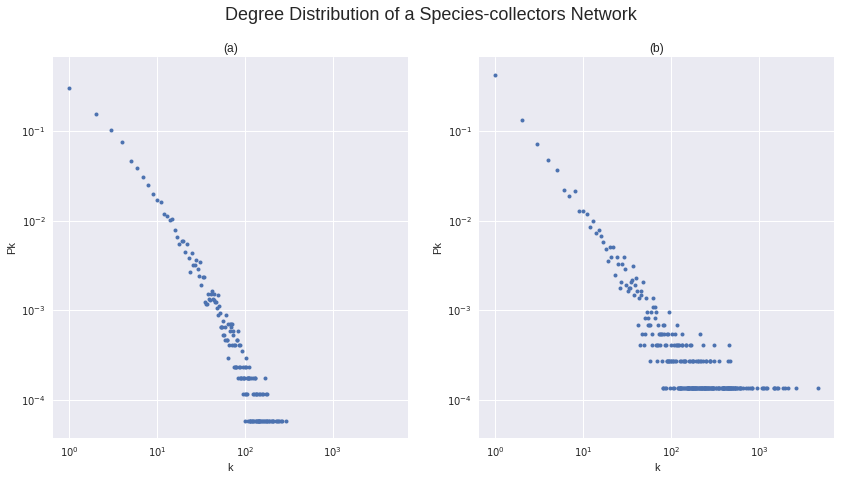

In [11]:
plt.figure(1, figsize=(14,7))
plt.suptitle("Degree Distribution of a Species-collectors Network", fontsize=18)

ax1=plt.subplot(121)
plt.title('(a)', fontsize=12)
plt.loglog( bipartiteDegreeHist( B, bipartite_set=1 ), marker='o', ls='', ms=4 )
plt.ylabel('Pk')
plt.xlabel('k')

plt.subplot(122, sharex=ax1, sharey=ax1)
plt.title('(b)', fontsize=12)
plt.loglog( bipartiteDegreeHist( B, bipartite_set=0 ), marker='o', ls='', ms=4)
plt.ylabel('Pk')
plt.xlabel('k')

** Figure 1. Degree distributions for (a) the species set and (b) the collectors set of a species-collectors network. The figures were plotted using the linear binning method, where the proportion of nodes (Pk) for each value of degree (k) are represented as dots. Here the degree of each node only depends on the number of edges they hold, irrespective of their weights (non-weighted degree).**

The degree distribution of this netowork follows a power law for both species and collectors nodes sets, as shown in *Figure 1*. This indicates that the network is composed by a majority of less connected nodes and fewer ones that hold more links, which are known as hubs. For the species set, hubs are those species that were recorded by many different collectors, whereas lower-degree nodes represent species that were recorded by fewer collectors. Conversely, for the collectors set hubs are those collectors who have collected many species, whereas lower-degree nodes are those who have collected fewer ones.

*Figure 2* below shows what a species-collectors network looks like:

In [12]:
np.random.seed(101)
nodes_col = list(np.random.choice(
                    [ n for n,d in B.nodes(data=True) if d['bipartite']==0 and d['k']>25],
                    replace=False,
                    size=15))

nodes_sp =  list(set([ v for u,v in B.edges(nodes_col) ]))

# Build subgraph for visualization
B_sub = B.subgraph(nodes_col + nodes_sp)
edges = B_sub.edges()

In [13]:
pos = nx.layout.spring_layout(B_sub)

In [14]:
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Species-collectors Network', fontsize=18)
fig.axes[0].patch.set_alpha(0)

# draw collectors nodes
draw = nx.draw_networkx_nodes(B_sub, pos=pos, nodelist=nodes_col,
                       node_size=[ B_sub.node[n]['k'] for n in nodes_col ],
                       node_color='b',
                       alpha=0.9)
mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ n for n in nodes_col ]))

# draw species nodes
draw = nx.draw_networkx_nodes(B_sub, pos=pos, nodelist=nodes_sp,
                       node_size=[ B_sub.node[n]['k'] for n in nodes_sp ],
                       node_color='r',
                       alpha=0.5)
mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ n for n in nodes_sp ]))

# draw edges
spline = lambda x: x/100 - 1
draw = nx.draw_networkx_edges(B_sub, pos=pos, edgelist=edges,
                       width=[ spline(B_sub[u][v]['weight']) for u,v in edges ],
                       alpha=0.05)
mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ B_sub[u][v]['weight'] for u,v in edges ]))

mpld3.display()

** Figure 2. A subset of the species-collectors network $B$ built by randomly selecting a set of 15 collectors (with degrees higher or equal 25) and the species they have recorded. Blue and red nodes represent collectors and species respectively. Edges' thickness represent their weights and nodes' sizes depend on their degrees (k).** 

Now we might want to investigate some aspects of this network looking at specific sets of nodes. Interesting relationships and patterns may emerge when we link together nodes that share a common neighbor, which is the principle of bipartite graph projection. Let's look at two examples.

## 1.1 Discovery of groups of interest

One first aspect we can investigate using species-collectors networks is which species taxonomic or functional groups make the collectors community most distinguished in terms of their recording interests. For instance we might state that collectors interest may be split into two main classes, them being herbaceous specialists versus trees specialists, as I assumed in previous notebooks. Using these functional groups of interest to split the collectors community in this dataset was an intuitive choice of mine, as I had some idea on which might be relevant groups of interests of some of the most relevant collectors recording plants within the Cerrado biome in Central Brazil. However a more robust method for finding groups of interests irrespective of our background knowledge on the dataset is highly desirable as long as we manage to extend our analyses to different (possibly bigger) datasets. In other words, we must make the process of discovering groups of interests systematic and generalizable across datasets. One possible way to achieve this is by analysing the patterns of connectivity of a species-collectors network projected onto the species set.

### Projection onto the species set
For projecting the species-collectors network onto the species set we omit nodes from the collectors set and link together species nodes which share neighbors. Edges between two species nodes are weighted based on the number of collectors that have ever collected both of them. Therefore species that are more strongly linked were collected by a high number of "shared" collectors.

Given the high number of edges, it turns out that this projection was impractical to be done in my average-performance personal computer using the *networkx* library. Platforms for parallel graph processing such as *GraphX* would be more appropriate for projecting this network entirely. Here, for the purpose of visualization I will subset $B$ so that we can have a general view of the projection. From $B$ I will choose randomly 400 nodes from the species set which have degrees (`k`) greater than 30 as well as their neighbors from the collectors set. 

As I have stated above bipartite projections are often too strongly connected, and therefore less informative edges must be filtered out. For that we must use edge weighting metrics that are appropriate to answer our specific questions. For example we might want to reduce the relevance of common species (which tend to have higher degrees) when identifying groups of interest. This could be accomplished by use species node degree as a factor pulling down the weight of edges that emerge from it. However for the purpose of this notebook and for the sake of simplicity I will use the simple weighting metric, assigning the number of collectors shared by two species nodes to the edge linking them. To identify groups based on the connectivity of the nodes I will run the *Louvain algorithm* for community detection.

The code below subsets $B$ and builds the projected graph which will be assigned to `B_proj_sp`. *Figure 3* shows the resulting graph.

In [15]:
np.random.seed(33)
nodes_sp = list(np.random.choice(
                    [ n for n,d in B.nodes(data=True) if d['bipartite']==1 and d['k']>=30],
                    replace=False,
                    size=400, ))

nodes_col =  list(set([ v for u,v in B.edges(nodes_sp) ]))

# Build subgraph for visualization
B_sub = B.subgraph(nodes_col + nodes_sp)

# Build the projected graph
nodes_sp = [ n for n,d in B_sub.nodes(data=True) if d['bipartite']==1 ]
B_proj_sp = nx.bipartite.weighted_projected_graph(B_sub, nodes_sp)

B_proj_sp.name = "Species-collectors subset (projected onto the species set)"
print(nx.info(B_proj_sp))

Name: Species-collectors subset (projected onto the species set)
Type: Graph
Number of nodes: 400
Number of edges: 78300
Average degree: 391.5000


In [16]:
from community import best_partition

parts = best_partition(B_proj_sp, resolution=1.05) #louvain algorithm

for n in B_proj_sp:
    B_proj_sp.node[n]['group'] = parts[n]

In [17]:
pos = nx.layout.spring_layout(B_proj_sp, k=0.5)

In [18]:
nodes = [ n for n in B_proj_sp.nodes() ]

fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Species-collectors Network: projection onto the species set', fontsize=18)
fig.axes[0].patch.set_alpha(0)

# draw nodes
draw = nx.draw_networkx_nodes(B_proj_sp, pos=pos, nodelist=nodes,
                       node_size=[ (B_proj_sp.node[n]['k_weighted'])/5 for n in nodes ],
                       node_color=[ B_proj_sp.node[n]['group'] for n in nodes ],
                       cmap=plt.get_cmap('jet_r'),
                       alpha=0.9)

mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, 
                    labels=[ n+" (Group "+str(B_proj_sp.node[n]['group'])+")" for n in nodes ]))

mpld3.display()

**Figure 3. A projection of a subsetted species-network onto the species set. The subset was obtained by drawing randomly 400 species nodes with degrees higher than 30 from the original graph $B$. Network communities identified by the *Louvain* algorithm are represented in different collors, and edges between nodes were omitted in the figure.**

From *Figure 3* there are apparently 4 distinct groups of interest on this subsample. One interesting outcome is that dark blue nodes (group 3) are almost all moss species (I checked them manually), and are in fact a relevant functional group of interest. There are experient collectors in this dataset that have in fact dedicated much of their effort to collecting mosses, for instance *Câmara, PEAS*. As I am not familiar with many of those scientific names I was not able to assign species in the other communities (groups 0,1,2) to particular functional or taxonomic groups of interests. Maybe a botanist could have more insights looking at those communities.

## 1.2 Which collectors share interest in common sets of species? 

### Projection onto the collectors set
From species-collectors networks we can also investigate which collectors share interest in common groups of species. Similarly to what we have done in the previous section we can have a different view of the species-collectors network, this time by projecting it onto the collectors set. Nodes from the species set are omitted and weighted edges link together collectors who have recorded common species. The number of species shared by two recorders is represented as the edge's weight. From this view we might reason that strongly associated collectors tend to have similar profiles.

As the collectors set has less than half the size of the species set, the projection of the entire graph $B$ could be performed in this notebook, although it takes a while to run. Below I perform the projection:

In [19]:
nodes_colls = [ n for n,d in B.nodes(data=True) if d['bipartite']==0 ]
B_proj_col = nx.bipartite.weighted_projected_graph(B, nodes_colls) # this takes a while...
B_proj_col.name = "Species-collectors (projected onto the collectors set)"

print(nx.info(B_proj_col))

Name: Species-collectors (projected onto the collectors set)
Type: Graph
Number of nodes: 7308
Number of edges: 803977
Average degree: 220.0265


Although this projected graph is composed only by collectors nodes the number of edges is in fact much higher, in such a way that it becomes impractical to visualize the entire graph even in a specialized visualization tool as *Gephi*. Therefore I will get a subset for visualization by filtering edges on their weights. The function below performs such filtering:

In [20]:
def getSubgraph( G, weight_thresh=30 ):
    edges_sub = [ (u,v,d) for u,v,d in G.edges(data=True) if d['weight']>weight_thresh ]
    nodes_sub = [ (n, G.node[n]) for u,v,d in edges_sub for n in (u,v) ]

    G_sub = nx.Graph()
    G_sub.add_nodes_from(nodes_sub)
    G_sub.add_edges_from(edges_sub)
    
    return G_sub

Below, the filtered graph will be generated and saved for *Gephi* visualization.

In [21]:
B_sub = getSubgraph(B_proj_col)
B_sub.name = "Species-collectors subset (projected onto the collectors set)"
nx.write_gexf(B_sub, path='./graphs/n4_g1B_sub.gexf')

In [22]:
print(nx.info(B_sub))

Name: Species-collectors subset (projected onto the collectors set)
Type: Graph
Number of nodes: 568
Number of edges: 13073
Average degree:  46.0317


Now, in order to visualize the graph inside this notebook, I will get an even smaller subset, using a weight threshold of 250. The nodes composing this subset will be assigned to the variable `nodes_viz` and will also be used for subsetting the collectors co-working network, in order to facilitate the comparison. Also, I will perform a community analysis.

In [23]:
B_sub = getSubgraph(B_proj_col, weight_thresh=250)
nodes_viz = B_sub.nodes()

In [24]:
parts = best_partition(B_sub) #louvain algorithm

for n in B_sub:
    B_sub.node[n]['group'] = parts[n]

In [25]:
pos = nx.layout.spring_layout(B_sub, k=0.7)

In [26]:
nodes = [ n for n in B_sub.nodes() ]
edges = [ e for e in B_sub.edges() ]

fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Species-collectors Network: projection onto the collectors set', fontsize=18)
fig.axes[0].patch.set_alpha(0)

# draw nodes
draw = nx.draw_networkx_nodes(B_sub, pos=pos, nodelist=nodes,
                       node_size=[ (B_sub.node[n]['k_weighted'])/20 for n in nodes ],
                       node_color=[ B_sub.node[n]['group'] for n in nodes ],
                       cmap=plt.get_cmap('jet_r'),
                       alpha=0.9)

mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ n for n in nodes ]))

# draw edges
spline = lambda x: 0.005*x -1
draw = nx.draw_networkx_edges(B_sub, pos=pos, edgelist=edges,
                       width=[ spline(B_sub[u][v]['weight']) for u,v in edges ],
                       alpha=0.3)

mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ B_sub[u][v]['weight'] for u,v in edges ]))

mpld3.display()

** Figure 4. A projection of the subsetted species-collectors network onto the collectors set. Nodes with all edges weights lower than the threshold value (250) were filtered out for visualization purposes. Nodes sizes depend on their weighted degrees, representing the diversity of species weighted by the number of records of each species a collector has recorded; and colors represent the groups they have been placed in based on connectivity patterns, as indicated by running the *Louvain* algorithm. Edges weights represent the number of species two collectors have both recorded, not necessarily together.**

From *Figure 4* we are able to identify some collectors who share interest in particular sets of species. For example {*Ratter,JA*; *Proença, CEB*; *Heringer, EP*}, {*Irwin, HS*; *Anderson, WR*; *Eiten, G*} and {*Munhoz, CBR*; *Amaral, AG*; *Eugênio, CUO*} are three groups of collectors who share interest in more species among themselves than with other collectors in the network. Groups of recorders who share a higher number of recorded species are assigned to distinct communities, as the figure points out. However, one important aspect to note is that the information about who has in fact done field recordings with who cannot be drawn from a species-collectors network alone. For that we refer to another approach, the collectors co-working networks models which is presented next. 

---

# 2. Collectors co-working networks (CWN)

**Collectors co-working networks** are formed by collectors who have recorded species together in field. Edges are formed between pairs of collectors if they have co-authored occurrences, as drawn from entries of the `recordedBy` column. They are **weighted** according to the total number of occurrences two collectors have co-authored. Node degree (`k`) depends on the number of edges that is hold by that particular node. Weighted degree (`k_weighted`) is also calculated for each node, and in addition to the number of edges this metric also considers the weights of the node's edges.

Such networks can be thought of as social networks formed by field collectors, where 'social' means having done fieldwork together. One important aspect to note is that these networks are assembled by simply linking together author names that are responsible for each record. Therefore any information about particular species each collector has recorded or recordings locations/dates are not directly available on this networks. In order to answer such questions other approaches for building networks such as the species-collectors are more appropriate.

Here are some of the methods that I have defined in the last notebooks. They will be used for structuring the networks based on the occurrences tabular data.

In [27]:
def collectorsFromString( collStr, splitOn=';',filters=[ 'et al.'] ):
    # Return a list of names from a string of collectors `collStr` names separated by `splitOn`; 
    # Elements in the list `filter` are ignored
    collsList = [ col.strip() for col in collStr.split(splitOn) ]
    return set([ coll for coll in collsList if coll!='' and coll not in filters ])

def edgesFromClick(elements): 
    # Returns all the edges that make the nodes in the list `elements` a click
    ls=[]
    elements = list(set(elements))
    for i,s in enumerate(elements):
        for t in elements[i+1:]:
            ls.append((s,t))
    return ls

Now let's build the collectors co-working graph.

In [28]:
# Build graph
G = nx.Graph(name='Collectors co-working Network')
edges = Counter([  edge for r in occs['recordedBy'] for edge in edgesFromClick(collectorsFromString(str(r))) ])
G.add_weighted_edges_from([ (e1,e2, edges[(e1,e2)]) for e1, e2 in edges ])

# add weighted and non-weighted degrees attributes
nx.set_node_attributes( G, name = 'k_weighted', values = G.degree(weight='weight') )
nx.set_node_attributes( G, name = 'k', values = G.degree() )

# save graph and print info
nx.write_gexf(G, path='./graphs/n4_g2G.gexf')
print(nx.info(G))

Name: Collectors co-working Network
Type: Graph
Number of nodes: 4630
Number of edges: 11654
Average degree:   5.0341


Note that the collectors co-working network has significantly fewer collector nodes (4630 nodes) than there were in the species-collectors network (7308 nodes). This is probably due to the former's method of construction, as collectors who have only recorded species alone are not included. The fact that single-collector records are discarded is in fact a caveat for this type of network. *Figure 5* shows that degree distribution for $G$ also follows a power law (few hubs and many lower-k nodes).

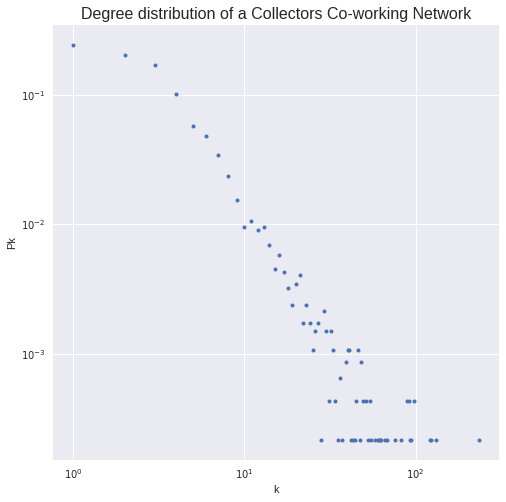

In [29]:
num_of_nodes = G.number_of_nodes()
y = [ i/num_of_nodes for i in nx.degree_histogram(G) ]

plt.title('Degree distribution of a Collectors Co-working Network', fontsize=16)
plt.loglog( y, marker='o', ls='', ms=4 )
plt.ylabel('Pk')
plt.xlabel('k')

** Figure 5. Degree distributions for a collectors co-working network. The figures was plotted using the linear binning method, where the proportion of nodes (Pk) for each value of degree (k) are represented as dots. Here the degree of each node only depends on the number of edges they hold, irrespective of their weights (non-weighted degree).**

Now let's visualize $G$. To compare this network with the projected species-collectors network in *Figure 4*, I will subset $G$ using only nodes which were assigned to the variable `nodes_viz` (these are the nodes presented in *Figure 4*). I will also perform another community analysis to check if communities differed on both networks.

In [30]:
def getSubgraph( G, weight_thresh=30 ):
    edges_sub = [ (u,v,d) for u,v,d in G.edges(data=True) if d['weight']>weight_thresh ]
    nodes_sub = [ (n, G.node[n]) for u,v,d in edges_sub for n in (u,v) ]

    G_sub = nx.Graph()
    G_sub.add_nodes_from(nodes_sub)
    G_sub.add_edges_from(edges_sub)
    
    return G_sub

In [31]:
G_sub = G.subgraph(nodes_viz)

In [32]:
from community import best_partition

parts = best_partition(G_sub) #louvain algorithm

for n in G_sub:
    G_sub.node[n]['group'] = parts[n]

In [33]:
nx.write_gexf(G_sub, path='./graphs/n4_g3G_sub.gexf')

In [34]:
pos=nx.layout.spring_layout(G_sub)

In [35]:
nodes = [ n for n in G_sub.nodes() ]
edges = [ e for e in G_sub.edges() ]

fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Collectors co-working network with edges from SCN', fontsize=18)
fig.axes[0].patch.set_alpha(0)

# draw nodes
draw = nx.draw_networkx_nodes(G_sub, pos=pos, nodelist=nodes,
                       node_size=[ (G_sub.node[n]['k']*2) for n in nodes ],
                       node_color=[ G_sub.node[n]['group'] for n in nodes ],
                       cmap=plt.get_cmap('jet_r'),
                       alpha=0.9)

mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ n for n in nodes ]))


# draw green edges
edges_bsub = [ e for e in B_sub.edges() ]
spline = lambda x: 0.005*x -1
draw = nx.draw_networkx_edges(B_sub, pos=pos, edgelist=edges_bsub,
                       width=[ spline(B_sub[u][v]['weight']) for u,v in edges_bsub ],
                       edge_color='g',
                       alpha=0.2)

# draw edges
spline = lambda x: 0.005*x
draw = nx.draw_networkx_edges(G_sub, pos=pos, edgelist=edges,
                       width=[ spline(G_sub[u][v]['weight']) for u,v in edges ],
                       edge_color='k',
                       alpha=0.7)


mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ G_sub[u][v]['weight'] for u,v in edges ]))


mpld3.display()

**Figure 6. A subset of the collectors co-working network $G$ with previously selected nodes. Nodes sizes refer to their non-weighted degrees (`k`), and black edges link together collectors who have co-authored species occurrences records, weighted by the number of shared records. Green edges originate from the projection of the species-collectors network into the collectors set, and were plotted on this figure for comparison of those perspectives.**

Instead of simply linking together collectors who have similar interests, collectors co-working networks gives us information on which collectors have in fact done fieldwork together, irresepective of their interests. *Figures 4 and 6* show that *Ratter,JA*, *Proença, CEB* and *Heringer, EP* for example are more strongly related in terms of species of mutual interest although they have not done much fieldwork together. The same can be observed for *Irwin, HS*, *Anderson, WR* and *Eiten, G*. However *Munhoz, CBR*, *Amaral, AG* and *Eugênio, CUO* do have common interest in many species and in addition have performed a considerable amount fieldwork together. Therefore combining both approaches can give us insights into how collectors perform fieldwork. 

In cases of shortage of resources for field expeditions it may happen that collectors with different interests are more willing to join efforts and help each other on recordings. This is common for example in graduate programs, where students must use shared resources for recording their own data. They will naturally form tight clusters on the collectors co-working network, with many lower-degree nodes (students) linked to few hubs (their professors). As some students conclude their graduate programs and continue their carreer as field recorders, they may change their patterns of connectivity significantly over time. A temporal analysis of these networks would be helpful if we wanted to look for these changes.

# Conclusions

**Species-collectors Networks** 
* Represented as non-directed weighted bipartite graphs, with distinct species and collectors node sets $B=(S_{col},S_{sp}, E)$;
* Projections usually hold a very large number of edges, which must be weighted and filtered according to the questions we are trying to answer;
* Degree distributions of both node sets follow a power law (typical of scale-free networks);
* Are more appropriate to inform us which collectors share interest on which taxonomic/functional species groups;
* Potentially helpful to identify species taxonomic and functional groups of interests which most optimally split the collectors community in terms of their recording interests;


**Collectors co-working networks**
* Represented as non-directed weighted graphs $G=(S,E)$;
* Comparatively smaller than species-collectors networks;
* Degree distribution of the nodes follows a power law (typical of scale-free networks);
* Are more appropriate to inform us which collectors have done field recordings together;
* Species information are not kept in the network's structure;
* Caveat: only occurrence records with more than 1 author are included. Therefore singleton collectors may appear as lower-degree nodes or even be missing.

** Final Considerations**
* Combining both perspectives help us better understand the contexts in which occurrence data is obtained;
* Temporal analyses of those networks could uncover temporal shifts of interests in species taxonomic/functional groups, potentially leading to biased sampling towards specific groups;


In [36]:
%%bash

cd graphs;
ls n4* | zip -@ n4_graphs.zip;

  adding: n4_g1_B.gexf (deflated 85%)
  adding: n4_g1B_sub.gexf (deflated 89%)
  adding: n4_g2G.gexf (deflated 89%)
  adding: n4_g3G_sub.gexf (deflated 88%)


In [37]:
%%HTML 
<style>
g.mpld3-xaxis{display:none;}
g.mpld3-yaxis{display:none;}
</style>